In [12]:
from __future__ import print_function

import os
import sys

sys.path.insert(0, os.path.abspath('../'))

import abupy
from abupy import six, xrange, range, reduce, map, filter, partial
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [6]:
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [36]:
from collections import namedtuple
from collections import OrderedDict


class StockTradeDays(object):
    def __init__(self, price_array, start_date, date_array=None):
        self.__price_array = price_array
        self.__date_array = self._init_days(start_date, date_array)
        self.__change_array = self.__init_change()
        self.stock_dict = self._init_stock_dict()
        
    def __init_change(self):
        price_float_array = [
            float(price_str) for price_str in self.__price_array
        ]
        pp_array = [
            (price1, price2) for price1, price2 in zip(price_float_array[:-1], price_float_array[1:])
        ]
        change_array = list(map(lambda pp: reduce(lambda a, b: round((b-a) / a, 3), pp), pp_array))
        change_array.insert(0, 0)
        return change_array
    
    def _init_days(self, start_date, date_array):
        if date_array is None:
            date_array = [
                str(start_date+ind) for ind, _ in enumerate(self.__price_array)
            ]
        else:
            
                date_array = [
                    str(date) for date in date_array
                ]
        return date_array

    def _init_stock_dict(self):
        stock_namedtuple = namedtuple('stock',
                                    ('date', 'price', 'change'))
        stock_dict = OrderedDict(
            (date, stock_namedtuple(date, price, change))
            for date, price, change in zip(self.__date_array, self.__price_array, self.__change_array)
        )
        return stock_dict

    def filter_stock(self, want_up=True, want_calc_sum=False):
        filter_func = (lambda p_day: p_day.change > 0) if want_up else (
        lambda p_day: p_day.change < 0)
        want_days = list(filter(filter_func, self.stock_dict.values()))

        if not want_calc_sum:
            return want_days
        change_sum = 0.0
        for day in want_days:
            change_sum +=day.change
        return change_sum

    def __str__(self):
        return str(self.stock_dict)
    __repr__ = __str__

    def __iter__(self):
        for key in self.stock_dict:
            yield self.stock_dict[key]

    def __getitem__(self, ind):
        date_key = self.__date_array[ind]
        return self.stock_dict[date_key]

    def __len__(self):
        return len(self.stock_dict)

        

In [38]:
price_array =  '30.14,29.58,26.36,32.56,32.82'.split(',')
date_base = 20170809
trade_days = StockTradeDays(price_array, date_base)
trade_days

OrderedDict([('20170809', stock(date='20170809', price='30.14', change=0)), ('20170810', stock(date='20170810', price='29.58', change=-0.019)), ('20170811', stock(date='20170811', price='26.36', change=-0.109)), ('20170812', stock(date='20170812', price='32.56', change=0.235)), ('20170813', stock(date='20170813', price='32.82', change=0.008))])

In [39]:
print('trade_days对象长度为：{}'.format(len(trade_days)))

trade_days对象长度为：5


In [40]:
from collections import Iterable
if isinstance(trade_days, Iterable):
    for day in trade_days:
        print(day)

stock(date='20170809', price='30.14', change=0)
stock(date='20170810', price='29.58', change=-0.019)
stock(date='20170811', price='26.36', change=-0.109)
stock(date='20170812', price='32.56', change=0.235)
stock(date='20170813', price='32.82', change=0.008)


In [41]:
trade_days.filter_stock()

[stock(date='20170812', price='32.56', change=0.235),
 stock(date='20170813', price='32.82', change=0.008)]

In [44]:
from abupy import ABuSymbolPd
price_array = ABuSymbolPd.make_kl_df('TSLA', n_folds=2).close.tolist()
date_array = ABuSymbolPd.make_kl_df('TSLA',n_folds=2).date.tolist()
price_array[:5], date_array[:5]

([222.49, 223.54, 223.57, 224.82, 225.01],
 [20140723, 20140724, 20140725, 20140728, 20140729])

In [45]:
trade_days = StockTradeDays(price_array, date_base, date_array)
print('trade_days对象长度为:{}'.format(len(trade_days)))
print('最后一天交易数据为：{}'.format(trade_days[-1]))

trade_days对象长度为:504
最后一天交易数据为：stock(date='20160726', price=225.93, change=-0.018)


### 2.3.2 继承和多态

In [46]:
import six
from abc import ABCMeta, abstractmethod


class TradeStrategyBase(six.with_metaclass(ABCMeta, object)):
    """
        交易策略抽象基类
    """
    @abstractmethod
    def buy_strategy(self, *args, **kwargs):
        # 买入策略基类
        pass
    
    @abstractmethod
    def sell_strategy(self, *args, **kwargs):
        # 卖出策略基类
        pass
    
class TradeStrategy1(TradeStrategyBase):
    """
        交易策略1:追涨策略，当股价上涨一个阈值默认为7%时
        买入股票并持有s_keep_stock_threshold(20)天
    """
    s_keep_stock_threshold = 20
    
    def __init__(self):
        self.keep_stock_day = 0
        self.__buy_change_threshold = 0.07
        
    def buy_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day == 0 and trade_day.change > self.__buy_change_threshold:
            # 当没有持有股票的时候self.keep_stock_day == 0 并且
            # 符合买入条件上涨一个阈值，买入
            self.keep_stock_day += 1
        elif self.keep_stock_day > 0:
            # >0 代表持有股票，持有股票天数递增
            self.keep_stock_day += 1
            
    def sell_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day >= TradeStrategy1.s_keep_stock_threshold:
            self.keep_stock_day = 0
            
    @property
    def buy_change_threshold(self):
        return self.__buy_change_threshold
    
    @buy_change_threshold.setter
    def buy_change_threshold(self, buy_change_threshold):
        if not isinstance(buy_change_threshold, float):
            raise TypeError('buy_change_threshold must be float!')
        self.__buy_change_threshold = round(buy_change_threshold, 2)

In [48]:
class TradeLoopBack(object):
    """
        交易回测系统
    """
    def __init__(self, trade_days, trade_strategy):
        """
            使用上一节封装的stocktradedays类和本节编写的交易策略类
            TradeStrategyBase类初始化交易系统
            :param trade_days: StockTradeDays 交易数据序列
            :param trade_strategy: TradeStrategyBase 交易策略
        """
        self.trade_days  = trade_days
        self.trade_strategy = trade_strategy
        self.profit_array = []
        
    def execute_trade(self):
        """
        执行交易回测
        
        """
        for ind, day in enumerate(self.trade_days):
            """
                以时间驱动，完成交易回测
            """
            if self.trade_strategy.keep_stock_day > 0:
                self.profit_array.append(day.change)
                
            if hasattr(self.trade_strategy, 'buy_strategy'):
                # 买入策略
                self.trade_strategy.buy_strategy(ind, day, self.trade_days)
                
            if hasattr(self.trade_strategy, 'sell_strategy'):
                # 卖出策略执行
                self.trade_strategy.sell_strategy(ind, day, self.trade_days)

In [53]:
trade_loop_back = TradeLoopBack(trade_days, TradeStrategy1())
trade_loop_back.execute_trade()
print('回测策略1 总盈亏为； {}%'.format(reduce(lambda a, b: a + b, trade_loop_back.profit_array)*100))

回测策略1 总盈亏为； 37.60000000000001%


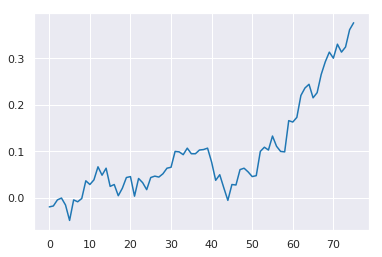

In [57]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize':(14, 7)})
plt.plot(np.array(trade_loop_back.profit_array).cumsum())

### 2.3.3 静态方法，类方法与property属性

回测策略1 总盈亏为：0.8000000000000004%


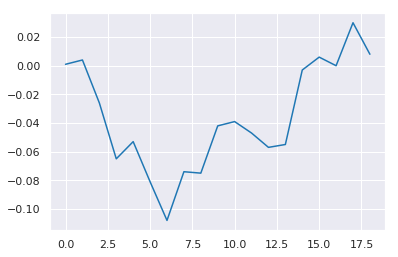

In [59]:
trade_strategy1 = TradeStrategy1()
# 买入阈值从0.0.7上升到0.1
trade_strategy1.buy_change_threshold = 0.1
trade_loop_back = TradeLoopBack(trade_days, trade_strategy1)
trade_loop_back.execute_trade()
print('回测策略1 总盈亏为：{}%'.format(reduce(lambda a, b: a + b, trade_loop_back.profit_array) * 100))
# 可视化profit_array
plt.plot(np.array(trade_loop_back.profit_array).cumsum());

In [60]:
class TradeStrategy2(TradeStrategyBase):
    """
        交易策略2:均值回复策略，当股价连续两个交易日下跌，
        且下跌幅度超过阈值默认s_buy_change_threshold(-10%),
        买入股票并持有s_keep_stock_threshold(10)天
    """
    # 买入后持有天数
    s_keep_stock_threshold = 10
    # 下跌买入阈值
    s_buy_change_threshold = -0.10
    
    def __init__(self):
        self.keep_stock_day = 0
        
    def buy_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day ==0 and trade_ind >= 1:
            """
                当没有持有股票的时候，self.keep_stock_day == 0 并且
                trade_ind > =1,不是交易开始的第一天，因为需要yesterday 数据
            """
            # trade_day.change <0 bool: 今天是否股价下跌
            today_down = trade_day.change < 0
            # 昨天是否股价下跌
            yesterday_down = trade_days[trade_ind - 1].change < 0
            # 两天总跌幅
            down_rate = trade_day.change + trade_days[trade_ind -1].change
            if today_down and yesterday_down and \
                down_rate < TradeStrategy2.s_buy_change_threshold:
                self.keep_stock_day += 1
            elif self.keep_stock_day > 0:
                self.keep_stock_day += 1
    
    def sell_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day >= TradeStrategy2.s_keep_stock_threshold:
            # 当吃还有股票天数超过阈值s_keep_stock_threshold，卖出股票
            self.keep_stock_day = 0
            
    @classmethod
    def set_keep_stock_threshold(cls, keep_stock_threshold):
        cls.s_keep_stock_threshold = keep_stock_threshold
        
    @staticmethod
    def set_buy_change_threshold(buy_change_threshold):
        TradeStrategy2.s_buy_change_threshold = buy_change_threshold    

回测策略2 总盈亏为：16.29999999999999%


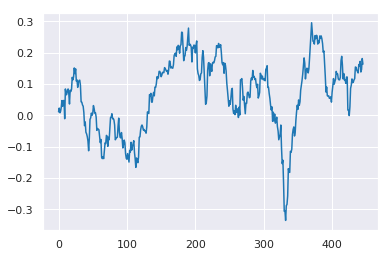

In [62]:
trade_strategy2 = TradeStrategy2()
trade_loop_back = TradeLoopBack(trade_days, trade_strategy2)
trade_loop_back.execute_trade()
print('回测策略2 总盈亏为：{}%'.format(reduce(lambda a, b: a+b, trade_loop_back.profit_array)*100))
plt.plot(np.array(trade_loop_back.profit_array).cumsum())

回测策略2 总盈亏为：4.800000000000011%


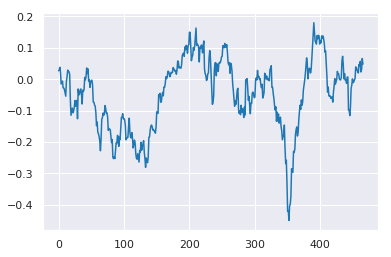

In [64]:
# 实例化一个新的TradeStrategy2类对象
trade_strategy2 = TradeStrategy2()
# 修改为买入后持有股票20天，默认为10天
TradeStrategy2.set_keep_stock_threshold(20)
# 修改股价下跌买入阀值为-0.08（下跌8%），默认为-0.10（下跌10%）
TradeStrategy2.set_buy_change_threshold(-0.08)
# 实例化新的回测对象trade_loop_back
trade_loop_back = TradeLoopBack(trade_days, trade_strategy2)
# 执行回测
trade_loop_back.execute_trade()
print('回测策略2 总盈亏为：{}%'.format(reduce(lambda a, b: a + b, trade_loop_back.profit_array) * 100))
# 可视化回测结果
plt.plot(np.array(trade_loop_back.profit_array).cumsum());

## 2.4 性能效率
### 2.4.1 itertools的使用

In [66]:
import itertools

In [67]:
items = [1, 2, 3]
for item in itertools.permutations(items):
    print(item)

(1, 2, 3)
(1, 3, 2)
(2, 1, 3)
(2, 3, 1)
(3, 1, 2)
(3, 2, 1)


In [68]:
for item in itertools.combinations(items, 2):
    print(item)

(1, 2)
(1, 3)
(2, 3)


In [69]:
for item in itertools.combinations_with_replacement(items, 2):
    print(item)

(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)


In [70]:
ab = ['a', 'b']
cd = ['c', 'd']
# 针对ab， cd两个集合进行排列组合
for item in itertools.product(ab, cd):
    print(item)

('a', 'c')
('a', 'd')
('b', 'c')
('b', 'd')


In [72]:
def calc(keep_stock_threshold, buy_change_threshold):
    """
    :param keep_stock_threshold: 持股天数
    :param buy_change_threshodl: 下跌买入阈值
    :return:盈亏情况， 输入的持股天数，输入的下跌买入阈值
    """
    # 实例化TradeStrategy2
    trade_strategy2 = TradeStrategy2()
    # 通过类方法设置买入后持股天数
    TradeStrategy2.set_keep_stock_threshold(keep_stock_threshold)
    # 通过类方法设置下跌买入阈值
    TradeStrategy2.set_buy_change_threshold(buy_change_threshold)
    # 进行回测
    trade_loop_back = TradeLoopBack(trade_days, trade_strategy2)
    trade_loop_back.execute_trade()
    # 计算回测结果的最终盈亏值profit
    profit = 0.0 if len(trade_loop_back.profit_array) == 0 else \
        reduce(lambda a,b: a+b, trade_loop_back.profit_array)
    # 返回值profit和函数的两个输入参数
    return profit, keep_stock_threshold, buy_change_threshold

# 测试，使用上一节的参数
calc(20, -0.08)

(0.04800000000000011, 20, -0.08)

In [77]:
# range集合，买入后持股天数从2天到30天，间隔两天
keep_stock_list = list(range(2, 30, 2))
print('持股天数参数组:{}'.format(keep_stock_list))
# 下跌买入阈值从-0.05到-0.15，即从下跌5%到15%
buy_change_list = [buy_change/100.0 for buy_change in xrange(-5, -16, -1)]
print('下跌阈值参数组:{}'.format(buy_change_list))

持股天数参数组:[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
下跌阈值参数组:[-0.05, -0.06, -0.07, -0.08, -0.09, -0.1, -0.11, -0.12, -0.13, -0.14, -0.15]


In [78]:
result = []
for keep_stock_threshold, buy_change_threshold in itertools.product(
    keep_stock_list, buy_change_list):
    # 使用calc计算参数对应的最终盈利，结果加入result序列
    result.append(calc(keep_stock_threshold,buy_change_threshold))
print('笛卡尔积参数集合总共结果为：{}'.format(len(result)))

笛卡尔积参数集合总共结果为：154


In [79]:
# [::-1]将整个排序结果反转，反转后盈亏收益从最高向低排序
# [:10]取出收益最高的前10个组合查看
sorted(result)[::-1][:10]

[(0.4690000000000002, 28, -0.13),
 (0.4690000000000002, 28, -0.14),
 (0.4690000000000002, 28, -0.15),
 (0.4690000000000002, 26, -0.13),
 (0.4690000000000002, 26, -0.14),
 (0.4690000000000002, 26, -0.15),
 (0.4690000000000002, 24, -0.13),
 (0.4690000000000002, 24, -0.14),
 (0.4690000000000002, 24, -0.15),
 (0.4690000000000002, 22, -0.13)]

### 2.4.2多进程和多线程